# Extracción de Características de Imagen con Manos
---
**Montar la carpeta de Google Drive y definir constantes para trabajar**

In [ ]:
ColabNotebook = 'google.colab' in str(get_ipython())

if ColabNotebook:
    # monta G-drive en entorno COLAB
    from google.colab import drive
    drive.mount('/content/drive/')

    # carpeta donde se encuentran archivos .py auxiliares
    FUENTES_DIR = '/content/drive/MyDrive/Colab Notebooks/FUENTES/'
    DATOS_DIR = '/content/drive/MyDrive/Colab Notebooks/DATOS/'      # carpeta donde se encuentran los datasets
else:
    # configuración para notebook con instalación LOCAL
    FUENTES_DIR = '../Fuentes'         # carpeta donde se encuentran archivos .py auxiliares
    DATOS_DIR   = '../Datos/' # carpeta donde se encuentran los datasets

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


**Propiedades Geométricas de una Imagen**

In [ ]:
from skimage.measure import regionprops, find_contours
from skimage.filters import threshold_otsu
from skimage.morphology import closing, square
from skimage.segmentation import clear_border
from skimage import io
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import glob
import math

arch_img = DATOS_DIR + '/Fingers/samples/1L.png'
imagen = io.imread(arch_img)

# busca umbral global con método estadístico de Otsu
umbral = threshold_otsu(imagen)

# binariza la imagen
imagen_bn = (imagen > umbral)*1

# cierra pequeños huecos/cortes que pudiera tener la imagen de la mano
imagen_bn = closing(imagen_bn, square(3))

# remueve artefactos que pudiera tener la imagen en los bordes
imagen_lista = clear_border(imagen_bn)

# obtiene valores geométricos a partir de las regiones (objetos "aislados") en la imagen
regiones = regionprops(imagen_lista)

# datos de la primera región. Debería ser la única si la mano fue segmentada correctamente
region = regiones[0]

for prop in region:
  if prop not in ['convex_image', 'coords', 'image_filled', 'image', 'image_convex', 'moments', 'moments_central', 'moments_normalized', 'moments_hu']:
    print('%20s:    '% prop, region[prop])

                area:     379
           area_bbox:     798
         area_convex:     476
         area_filled:     379
   axis_major_length:     36.50248886655961
   axis_minor_length:     15.945700479865366
                bbox:     (9, 22, 47, 43)
            centroid:     (31.350923482849606, 31.522427440633244)
      centroid_local:     [22.35092348  9.52242744]
        eccentricity:     0.8995398454257507
equivalent_diameter_area:     21.967197988242077
        euler_number:     1
              extent:     0.474937343358396
  feret_diameter_max:     40.85339643163099
      inertia_tensor:     [[27.23102735 25.20971728]
 [25.20971728 71.93753873]]
inertia_tensor_eigvals:     [83.27698084083175, 15.89158523709866]
               label:     1
         orientation:     -0.42269126497968534
           perimeter:     103.94112549695429
   perimeter_crofton:     101.22388322514473
               slice:     (slice(9, 47, None), slice(22, 43, None))
            solidity:     0.79621848739

**Grafica imagen original, imagen binarizada y contorno**

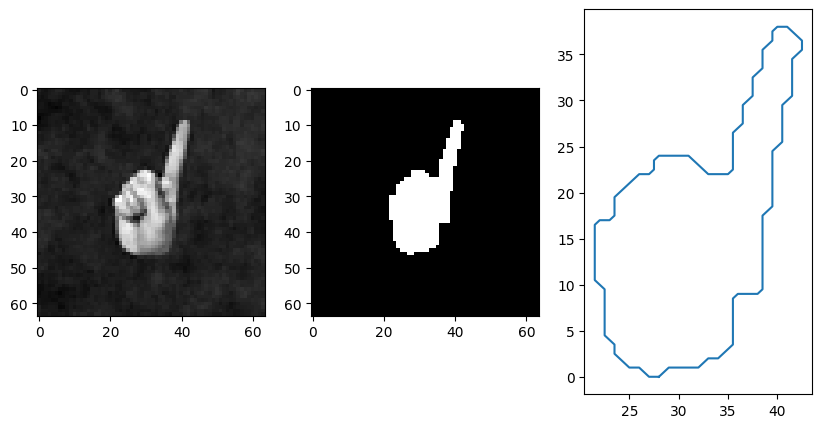

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(10,5))
axs[0].imshow(imagen, cmap='gray')
axs[1].imshow(imagen_bn, cmap='gray')

contour = find_contours(imagen_bn, 0.5)[0]
y, x = contour.T

axs[2].plot(x, y.max()-y)


### Gráfica de una imagen de escala de grises como una superficie en 3D
La intensidad del pixel se muestra como altura

In [ ]:
def plot_grayscale_surface(img, escala):

    height, width = img.shape  # Dimensiones de la imagen

    # Crea una malla de coordenadas
    x = np.linspace(0, width - 1, width)
    y = np.linspace(0, height - 1, height)
    x, y = np.meshgrid(x, y)

    # Crea la superficie 3D
    fig = go.Figure(data=[go.Surface(z=img*escala, x=x, y=y, colorscale='Gray', cmin=0, cmax=255*escala)])

    # Actualiza el diseño de la figura
    fig.update_layout(
        title='Superficie de  Imagen en Escala de Grises',
        scene=dict(
            xaxis_title='Ancho',
            yaxis_title='Alto',
            zaxis_title='Intensidad de Gris',
        ),
        width=700,  # Ancho de la figura
        height=700,  # Altura de la figura
        margin=dict(l=50, r=0, b=0, t=50)  # Márgenes de la figura
    )

    fig.show()

# Muestra plot de imagen, escala reduce la intensidad (y la altura) para mejor visualización
plot_grayscale_surface(imagen, escala=0.1)


Imágenes de los pasos de extracción de características

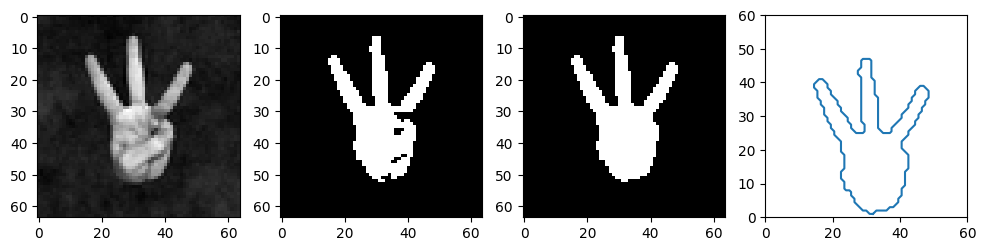

In [ ]:
arch_img = DATOS_DIR + '/Fingers/samples/3L.png'
imagen = io.imread(arch_img)

# # busca umbral global con método estadístico de Otsu
umbral = threshold_otsu(imagen)

# # binariza la imagen
imagen_bn = (imagen > umbral)*1

# # cierra pequeños huecos/cortes que pudiera tener la imagen de la mano
imagen_cl = closing(imagen_bn, square(3))

# # remueve artefactos que pudiera tener la imagen en los bordes
imagen_lista = clear_border(imagen_cl)

# obtiene valores geométricos a partir de las regiones (objetos "aislados") en la imagen
regiones = regionprops(imagen_lista)

# datos de la primera región. Debería ser la única si la mano fue segmentada correctamente
region = regiones[0]

fig, axs = plt.subplots(1,4, figsize=(12,5))
axs[0].imshow(imagen, cmap='gray')
axs[1].imshow(imagen_bn, cmap='gray')
axs[2].imshow(imagen_cl, cmap='gray')

contour = find_contours(imagen_cl, 0.5)[0]
y, x = contour.T

axs[3].set_aspect('equal', 'box')
axs[3].set_xlim([0, 60])
axs[3].set_ylim([0, 60])
axs[3].plot(x, y.max()-y+1)



Gráfico de centroide, eje mayor, eje menor y boundingbox

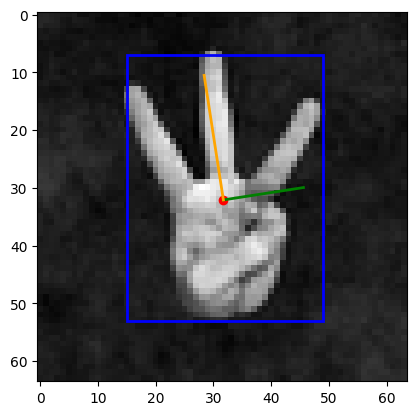

In [ ]:
# Encontrar propiedades de las regiones
regions = regionprops(imagen_cl)

# Crear una figura para mostrar la imagen
fig, ax = plt.subplots()
ax.imshow(imagen, cmap='gray')

# Dibujar el contorno de la región
for region in regions:
    y, x = region.centroid
    perimeter = region.perimeter
    # centroide de la figura en rojo
    plt.scatter(x, y, c='red')  # Marcar el punto medio
    contour = region.bbox
    #bounding box (caja contenedora) en azul
    rect = plt.Rectangle((contour[1], contour[0]), contour[3] - contour[1], contour[2] - contour[0],
                         fill=False, edgecolor='blue', linewidth=2)  # Dibujar el contorno
    ax.add_patch(rect)

   # Obtener la información de la elipse ajustada a la región
    major_axis_length = region.major_axis_length
    minor_axis_length = region.minor_axis_length
    orientation = region.orientation

    # Calcular los extremos del eje mayor y el eje menor
    y0, x0 = region.centroid
    x1 = x0 + np.cos(orientation) * 0.5 * minor_axis_length
    y1 = y0 - np.sin(orientation) * 0.5 * minor_axis_length
    x2 = x0 - np.sin(orientation) * 0.5 * major_axis_length
    y2 = y0 - np.cos(orientation) * 0.5 * major_axis_length

    # Dibujar el eje menor y el eje mayor
    plt.plot((x0, x1), (y0, y1), color='green', linewidth=2)  # Eje menor en verde
    plt.plot((x0, x2), (y0, y2), color='orange', linewidth=2)  # Eje mayor en naranja

# Mostrar la imagen con el punto medio y el contorno
plt.show()

Máscara de la imagen y su versión convexa

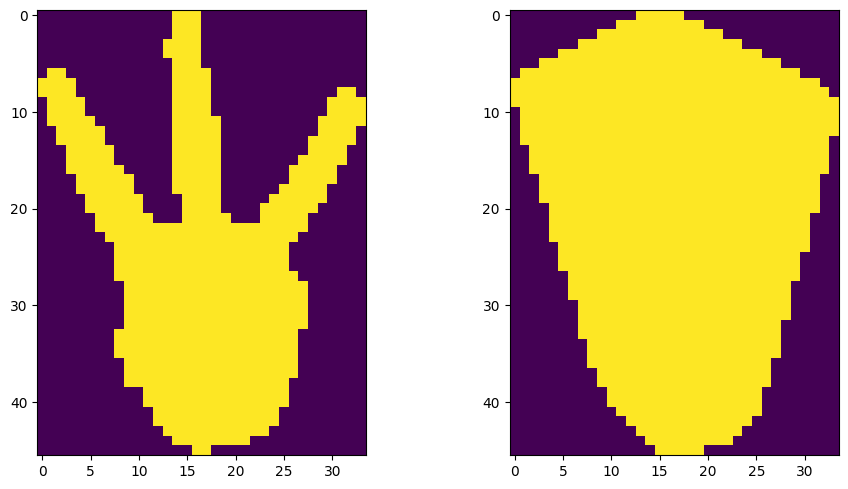

In [ ]:
# Crear una figura para mostrar la imagen
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Dibujar contorno, ejes mayor y menor en la primera imagen
ax[0].imshow(regions[0].image_filled)
ax[1].imshow(regions[0].convex_image)

plt.tight_layout()
plt.show()